# Prediction - European Calls

In [2]:
%run key_imports.py
%run bs.py
%run nn_archi.py
%run utils.py

X_df = pd.read_csv("datasets/bs.csv")
feat_names = ['log(S/K)', 'ttm']
f_to_i = lambda x: feat_names.index(x)
Xs = X_df[feat_names].values
ys = X_df['call_true']

print("BASELINE MSE: ", np.mean((ys - ys.mean()) ** 2))
print("BASELINE MAE: ", np.mean(np.abs(ys - ys.mean())))

all_res = []

BASELINE MSE:  0.27744778604092013
BASELINE MAE:  0.3417168805512335


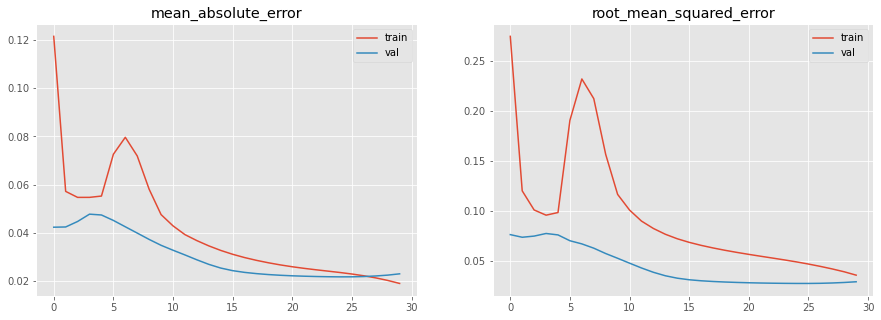

In [3]:
HIDDEN_UNITS = 100
LAYERS = 2
dropout_ratio = 0.0
HIDDEN_ACT = 'softplus'
N_FEATS = 2
OUTPUT_ACT = 'softplus'
DROPOUT_RATIO = 0.0
LR = 1e-3
BATCH_SIZE = 32
EPOCHS = 30
BATCH_NORM = False

loss_fn = tf.keras.losses.MeanSquaredError()

METRICS = [tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError()]
VAL_SPLIT = 0.2
CALLBACKS = [EarlyStopping(patience=5)]


opt = Adam(learning_rate = LR)
ffn = make_model(N_FEATS, 
                 HIDDEN_UNITS, 
                 LAYERS, 
                 DROPOUT_RATIO, 
                 HIDDEN_ACT, 
                 OUTPUT_ACT, 
                 BATCH_NORM)


ffn.compile(optimizer=opt, loss=loss_fn, metrics = METRICS)
start = time.time()
history = ffn.fit(Xs, ys, 
                  epochs = EPOCHS, 
                  batch_size=BATCH_SIZE, 
                  validation_split = VAL_SPLIT,
                  shuffle=False,
                  verbose = 0,
                  callbacks=CALLBACKS)
end = time.time()

metrics = ['mean_absolute_error', 'root_mean_squared_error']
fig, ax = plt.subplots(figsize=(15, 5), ncols = 2)
for i, metric in enumerate(metrics):
    ax[i].plot(history.history[metric], label="train")
    ax[i].plot(history.history[f"val_{metric}"], label="val")
    ax[i].legend()
    ax[i].set_title(metric)

<Axes3DSubplot:title={'center':'Surface'}, xlabel='Moneyness', ylabel='ttm'>

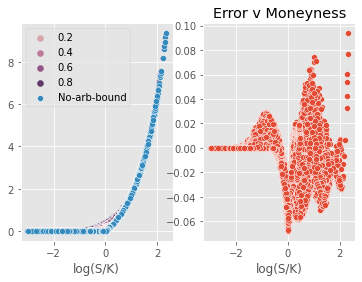

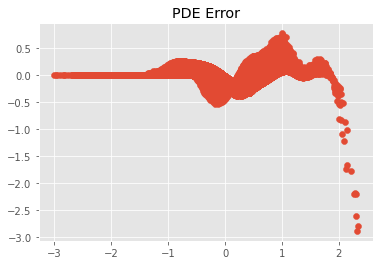

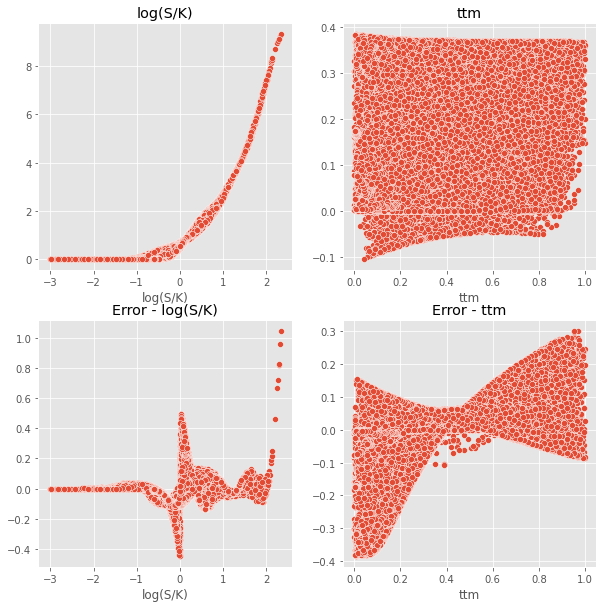

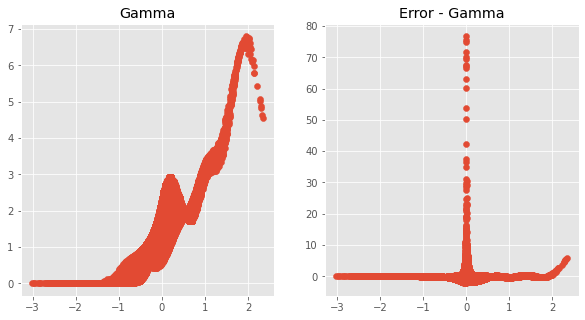

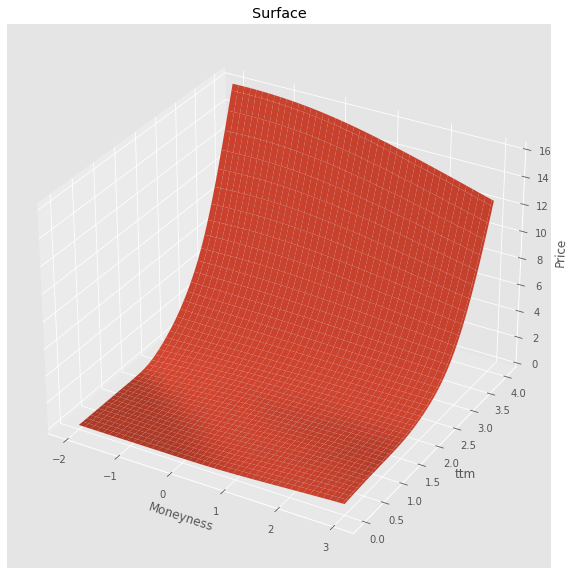

In [4]:
"""
Prediction Errors
"""
model = ffn
moneyness = np.exp(Xs[:, f_to_i("log(S/K)")])
ttm = np.exp(Xs[:, f_to_i("ttm")])
true = X_df['call_true']
intrinsic_val = np.maximum(moneyness - 1.0, 0)
preds = model.predict(Xs)
try:
    preds = preds.reshape(-1)
except:
    pass

"""
Compute all Gradients, Hessian
"""

X_tensor = tf.Variable(Xs)
with tf.GradientTape() as tape2:
    with tf.GradientTape() as tape:
        output = model(X_tensor)
        grads = tape.gradient(output, X_tensor)
    hessian1 = tape2.gradient(grads[:, f_to_i("log(S/K)")], X_tensor)

grads = grads.numpy()
hessian_moneyness = hessian1.numpy()[:, [0]]
    
all_res += [bs_eval_wrapper(X_df, 
                    true_val = X_df['call_true'].values, 
                    preds = preds,
                    grads = grads,
                    hessian_moneyness = hessian_moneyness,
                    lower_bound = intrinsic_val, 
                    upper_bound = None,
                    METHOD = "standard_ffn"
                    )]

"""
Visualise call surface
"""
SK = np.linspace(-2, 3, 128) 
ts = np.linspace(0, 4, 128)
X = np.array(list(product(SK, ts)))
visualise_surface(SK, ts, model(X).numpy())

# NN with a homogeneity hint

In [5]:
import time

CALLBACKS = [EarlyStopping(patience=5)]
opt = Adam(learning_rate = 1e-1)

intrinsic_value = np.maximum(np.exp(Xs[:,0]) - 1.0 ,0 )
gated_model = homogeneity_network(2, 100, seed = 42)
gated_model.compile(optimizer=opt, loss=loss_fn, metrics = METRICS)
start = time.time()
history = gated_model.fit([Xs[:,0], Xs[:,1]], 
                    ys, 
                  epochs = EPOCHS, 
                  batch_size=BATCH_SIZE, 
                  validation_split = VAL_SPLIT,
                  verbose = 0,
                  shuffle=True,
                  callbacks=CALLBACKS)
end = time.time()
print(end - start)

17.065085887908936


<Axes3DSubplot:title={'center':'Surface'}, xlabel='Moneyness', ylabel='ttm'>

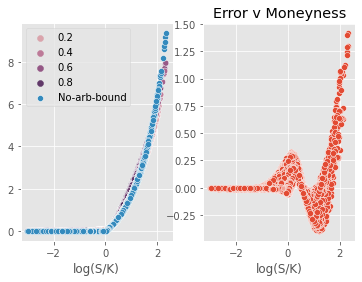

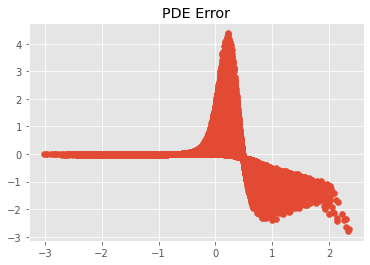

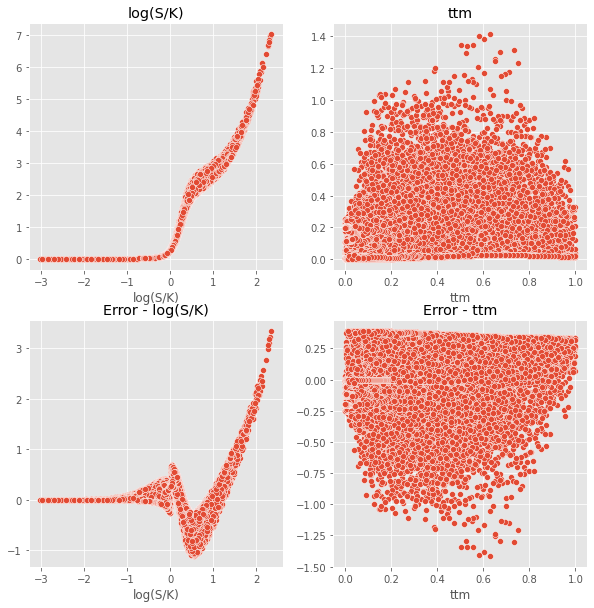

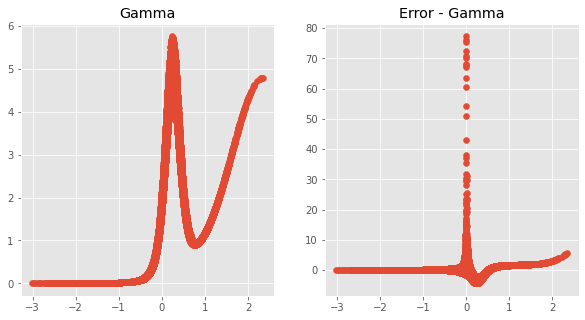

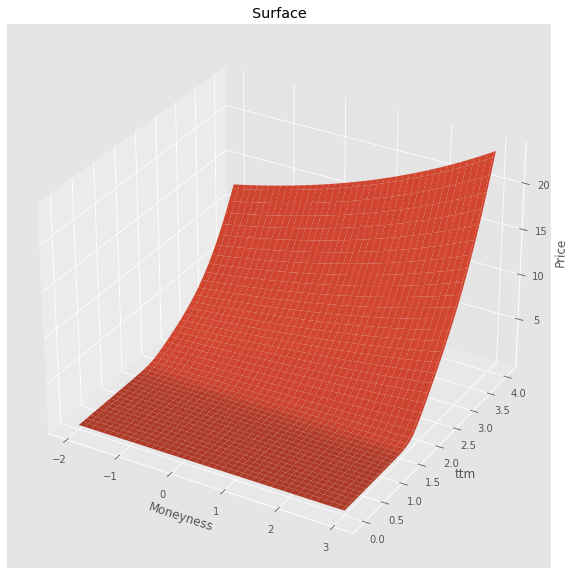

In [6]:
preds = (gated_model.predict([Xs[:,0], Xs[:,1]]).reshape(-1)).reshape(-1)

"""
Compute all Gradients, Hessian
"""

X_tensor = tf.Variable(Xs)
with tf.GradientTape() as tape2:
    with tf.GradientTape() as tape:
        output = gated_model([X_tensor[:,0], X_tensor[:,1]])
        grads = tape.gradient(output, X_tensor)
    hessian1 = tape2.gradient(grads[:, f_to_i("log(S/K)")], X_tensor)
    
grads = grads.numpy()
hessian_moneyness = hessian1.numpy()[:, [0]]
    
all_res += [bs_eval_wrapper(X_df, 
                    true_val = X_df['call_true'].values, 
                    preds = preds,
                    grads = grads,
                    hessian_moneyness = hessian_moneyness,
                    lower_bound = intrinsic_val, 
                    upper_bound = None,
                    METHOD = "homogeneity_network"
                    )]

"""
Visualise call surface
"""
SK = np.linspace(-2, 3, 128) 
ts = np.linspace(0, 4, 128)
X = np.array(list(product(SK, ts)))
visualise_surface(SK, ts, gated_model([X[:,0], X[:,1]]).numpy())

# Polynomial Basis

<AxesSubplot:>

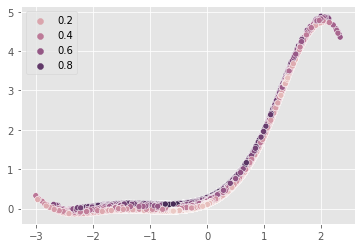

In [7]:
from sklearn.preprocessing import PolynomialFeatures, SplineTransformer
from sklearn.linear_model import LinearRegression, LogisticRegression
X2 = SplineTransformer(n_knots=5, degree=3, knots='uniform', extrapolation='constant').fit_transform(Xs)

reg = LinearRegression(fit_intercept=False).fit(X2, X_df['call_payoff'])
sns.scatterplot(x = Xs[:, f_to_i("log(S/K)")], 
                y = reg.predict(X2), 
                hue = Xs[:, f_to_i("ttm")])

# Neural PDE

In [8]:
dataset = tf.data.Dataset.from_tensor_slices((Xs, ys))

In [9]:
opt = Adam(learning_rate = LR)
model = make_model(N_FEATS, 
                 HIDDEN_UNITS, 
                 LAYERS, 
                 DROPOUT_RATIO, 
                 HIDDEN_ACT, 
                 OUTPUT_ACT, 
                 BATCH_NORM)

batched_dataset = dataset.batch(BATCH_SIZE)

@tf.function
def train(y, x_var):
    with tf.GradientTape() as model_tape:
        with tf.GradientTape() as hessian_tape:
            with tf.GradientTape() as grad_tape:
                output = model(x_var)
            gradients = grad_tape.gradient(output, x_var)
            hessian = hessian_tape.gradient(gradients[:,0], x_var)
            pde_loss = tf.math.reduce_mean((gradients[:,1] + x_var[:,1] * (-hessian[:,0] + gradients[:,0])) ** 2)
            pred_loss = tf.keras.losses.MeanSquaredError()(output, y)
            loss = pde_loss + pred_loss
            model_grad = model_tape.gradient(loss, model.trainable_variables)
            opt.apply_gradients(zip(model_grad, model.trainable_variables))
    return loss, pred_loss, pde_loss

losses = {"pde": [], "loss":[], "pred":[]}
for epoch in tqdm(range(EPOCHS)):
    temp_pred = []
    temp_pde = []
    temp_loss = []
    for step, (x, y_true) in enumerate(batched_dataset):
        x_var = tf.Variable(x)
        loss, pred_loss, pde_loss = train(y_true, x_var)
        temp_pred += [pred_loss.numpy()]
        temp_pde += [pde_loss.numpy()]
        temp_loss += [loss.numpy()]
    losses['pde'] += [np.mean(temp_pde)]
    losses['pred'] += [np.mean(temp_pred)]
    losses['loss'] += [np.mean(temp_loss)]

  0%|          | 0/30 [00:00<?, ?it/s]

<Axes3DSubplot:title={'center':'Surface'}, xlabel='Moneyness', ylabel='ttm'>

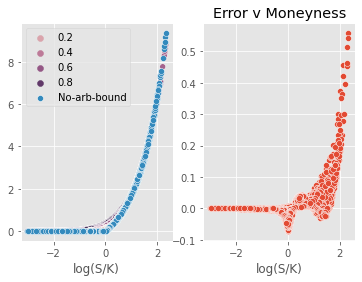

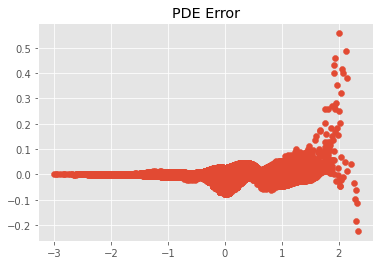

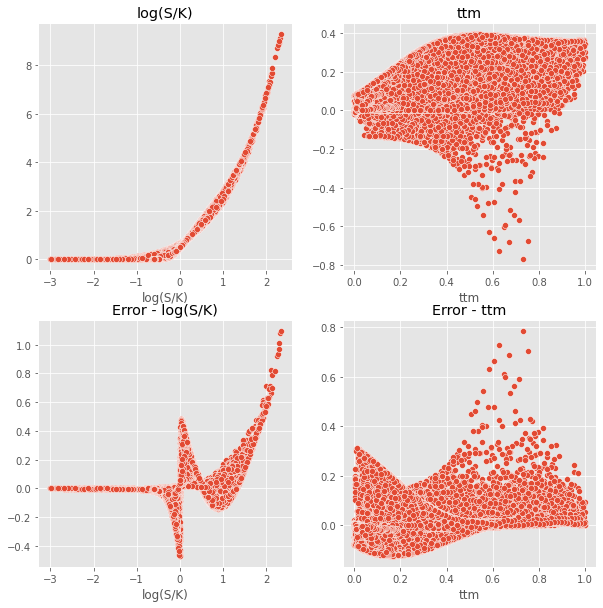

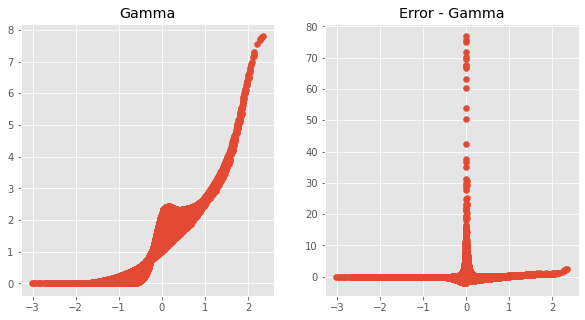

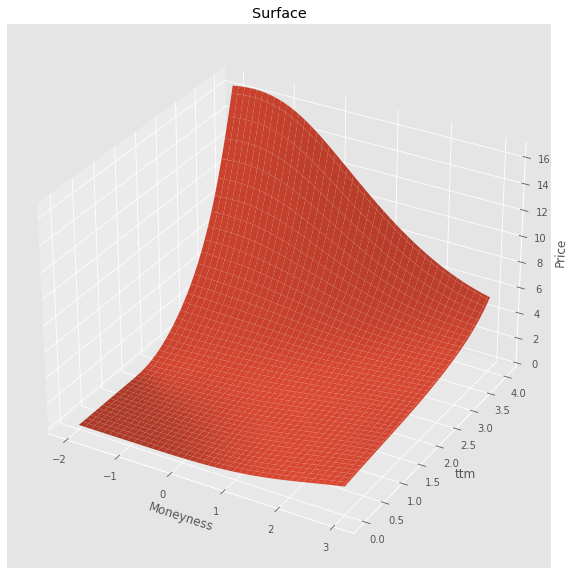

In [10]:
preds = model.predict(Xs).reshape(-1)
"""
Compute all Gradients, Hessian
"""

X_tensor = tf.Variable(Xs)
with tf.GradientTape() as tape2:
    with tf.GradientTape() as tape:
        output = model(X_tensor)
        grads = tape.gradient(output, X_tensor)
    hessian1 = tape2.gradient(grads[:, f_to_i("log(S/K)")], X_tensor)

grads = grads.numpy()
hessian_moneyness = hessian1.numpy()[:, [0]]
    
all_res += [bs_eval_wrapper(X_df, 
                    true_val = X_df['call_true'].values, 
                    preds = preds,
                    grads = grads,
                    hessian_moneyness = hessian_moneyness,
                    lower_bound = intrinsic_val, 
                    upper_bound = None,
                    METHOD = "ffn+neural_pde"
                    )]

"""
Visualise call surface
"""
SK = np.linspace(-2, 3, 128) 
ts = np.linspace(0, 4, 128)
X = np.array(list(product(SK, ts)))
visualise_surface(SK, ts, model(X).numpy())

In [16]:
all_res_df = pd.concat(all_res).T
print(all_res_df.to_latex())
all_res_df.style.background_gradient(axis = 1)

\begin{tabular}{lrrr}
\toprule
{} &  standard\_ffn &  homogeneity\_network &  ffn+neural\_pde \\
\midrule
pred\_l1                    &      0.022172 &             0.055315 &        0.011959 \\
pred\_l2                    &      0.028844 &             0.085589 &        0.019299 \\
pred\_l\_inf                 &      0.093755 &             1.415525 &        0.557627 \\
pred\_lower\_bound\_violation &      0.027328 &             0.223175 &        0.183304 \\
PDE\_mean                   &     -0.033249 &             0.144910 &        0.002128 \\
PDE\_l1                     &      0.111167 &             0.388884 &        0.011846 \\
PDE\_l2                     &      0.148716 &             0.707390 &        0.017840 \\
PDE\_l\_inf                  &      2.882793 &             4.383477 &        0.557461 \\
monotonicity\_error         &      0.000000 &             0.000000 &        0.000000 \\
time\_value\_error           &      0.022888 &             0.000000 &        0.032928 \\
convex\_e

,standard_ffn,homogeneity_network,ffn+neural_pde
pred_l1,0.022172,0.055315,0.011959
pred_l2,0.028844,0.085589,0.019299
pred_l_inf,0.093755,1.415525,0.557627
pred_lower_bound_violation,0.027328,0.223175,0.183304
PDE_mean,-0.033249,0.144910,0.002128
PDE_l1,0.111167,0.388884,0.011846
PDE_l2,0.148716,0.707390,0.017840
PDE_l_inf,2.882793,4.383477,0.557461
monotonicity_error,0.000000,0.000000,0.000000
time_value_error,0.022888,0.000000,0.032928


<AxesSubplot:ylabel='Count'>

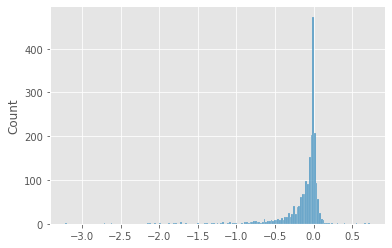

In [12]:
preds = model.predict(Xs).reshape(-1)
X_tensor = tf.Variable(Xs)
with tf.GradientTape() as tape:
    output = model(X_tensor)
    grads = tape.gradient(output, X_tensor)
    
delta = grads[:,0].numpy().reshape((-1, 32))
St = X_df['log(S/K)'].values.reshape((2048, -1))
payoff = X_df.groupby('path')['call_payoff'].mean().values
hedge_pnl = preds[::32] + np.sum(delta[:, :-1] * np.diff(St, axis = 1), axis = 1) - payoff

sns.histplot(hedge_pnl)